# <font color='#f78fb3'> **1 Overview**<br> </font> 


---
---
# <font color='#f78fb3'> **2 Setup**<br> </font> 

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
import sklearn.decomposition as dec
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Common imports
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.sparse import csc_matrix
from sparsesvd import sparsesvd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import mean_squared_error
from math import sqrt


# to make this notebook's output stable across runs
np.random.seed(42)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
# import seaborn to make nice plots
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

C:\Users\Mai\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def plot_data(X, y, n_cluster):
    palette = np.array(sns.color_palette("hls", n_cluster))

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    sc = ax.scatter(X[:,0], X[:,1], s=3,c=y, cmap="jet")
    # We add the labels for each digit.
    txts = []
    for i in range(n_cluster):
        # Position of each label.
        xtext, ytext = np.median(X[y == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
                PathEffects.Stroke(linewidth=3, foreground="w"),
                PathEffects.Normal()])
        txts.append(txt)    
        
        
def compare_truelabel_cluster(X, y, cluster):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    ax[0].scatter(X[:,0], X[:,1], s=3, c=y, cmap='jet')
    ax[1].scatter(X[:,0], X[:,1], s=3, c=cluster, cmap='jet')
    plt.axis('off')
    plt.show()
    
    
def show_image(images, n_images=5):
    nrows, ncols = 1, 5
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    plt.gray()
    for i in range(ncols * nrows):
        ax = plt.subplot(nrows, ncols, i + 1)
        ax.imshow(images.reshape(len(images),28,28)[i])
        plt.xticks([])
        plt.yticks([])    
            
    plt.show()


---
---
# <font color='#f78fb3'> **3 Data Preparation**<br> </font> 

### Full dataset

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.reshape(-1,784)
X_test = X_test.reshape(-1,784)

X_train_full.shape, X_test.shape

((60000, 784), (10000, 784))

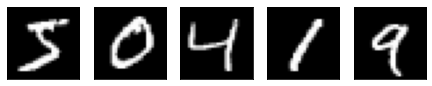

In [4]:
show_image(X_train_full[0:5], 5)

### Use a part of full dataset to reduce the training time

In [5]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[45000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[45000:]
X_test = X_test / 255.

X_train.shape, X_valid.shape, X_test.shape

((15000, 784), (5000, 784), (10000, 784))

---
---
# <font color='#f78fb3'> **4 PCA**<br> </font> 

### 1. Train model

In [6]:
pca = PCA()
X_train_pca = pca.fit(X_train)

### 2. Select number of principle components

153


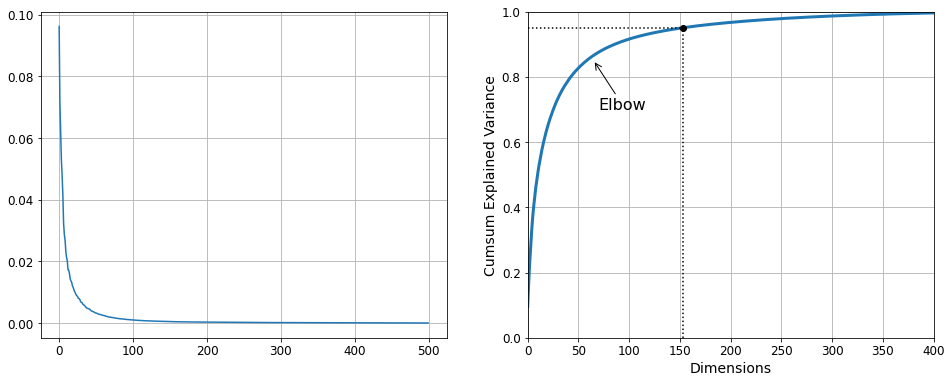

In [7]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d)
   
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax[0].plot(pca.explained_variance_ratio_[0:500])
ax[0].grid(True)

ax[1].plot(cumsum, linewidth=3)
ax[1].axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Cumsum Explained Variance")
ax[1].plot([d, d], [0, 0.95], "k:")
ax[1].plot([0, d], [0.95, 0.95], "k:")
ax[1].plot(d, 0.95, "ko")
ax[1].annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7), arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

### 3.  Fit and transform with 85% of variance

In [8]:
pca = PCA(n_components=0.85)
X_train_pca = pca.fit_transform(X_train)
X_recovered_pca = pca.inverse_transform(X_train_pca)

pca.n_components_, np.sum(pca.explained_variance_ratio_)

(60, 0.8523807103955257)

### 4. Plot transformed data

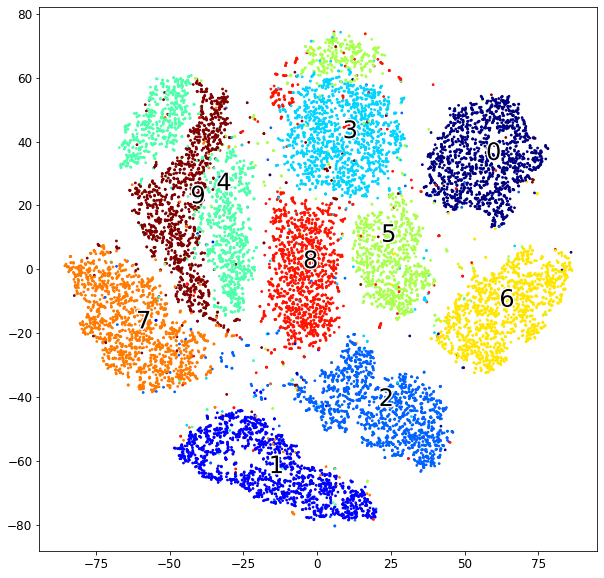

In [9]:
tsne = TSNE(n_components=2, random_state=42)
pca_tsne_value = tsne.fit_transform(X_train_pca)
plot_data(pca_tsne_value, y_train, 10)

---
---
# <font color='#f78fb3'> **5 SVD**<br> </font> 

### 1. Train model

In [10]:
U, S, V = np.linalg.svd(X_train)
S[0:10]

array([747.62823649, 255.5026409 , 237.44486297, 220.58915713,
       204.45551277, 182.29187181, 169.30560206, 151.21702539,
       149.81213795, 135.62240471])

### 2.  Select number of latent vars

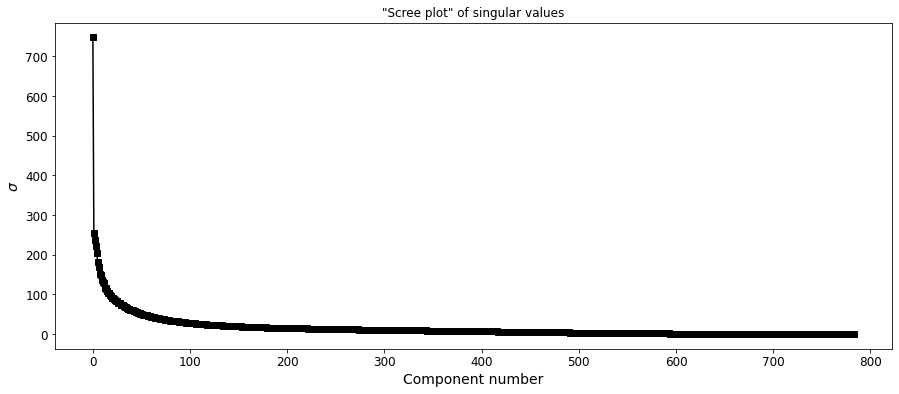

In [11]:
plt.figure(figsize=(15,6))
plt.plot(S, 'ks-')
plt.xlabel('Component number')
plt.ylabel('$\sigma$')
plt.title('"Scree plot" of singular values')
plt.show()

In [12]:
# list the components you want to use for the reconstruction
n_comps = np.arange(0,30)

# reconstruct the low-rank version of the picture
X_pred = U[:,n_comps]@np.diag(S[n_comps])@V[:,n_comps].T

In [13]:
X_train[0:3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
X_pred[0:3]

array([[-1.48088366e-16, -1.84571270e-16, -3.11626525e-17, ...,
         0.00000000e+00,  6.75169064e+00, -3.65673715e-01],
       [-3.83823703e-16, -2.12749341e-16,  2.55679620e-16, ...,
         0.00000000e+00,  5.23295521e+00,  1.58672147e+00],
       [-2.83722550e-16, -2.39493136e-16,  2.65863423e-17, ...,
         0.00000000e+00,  3.61726928e+00, -1.34550291e+00]])

### 3. Visualize latent vars

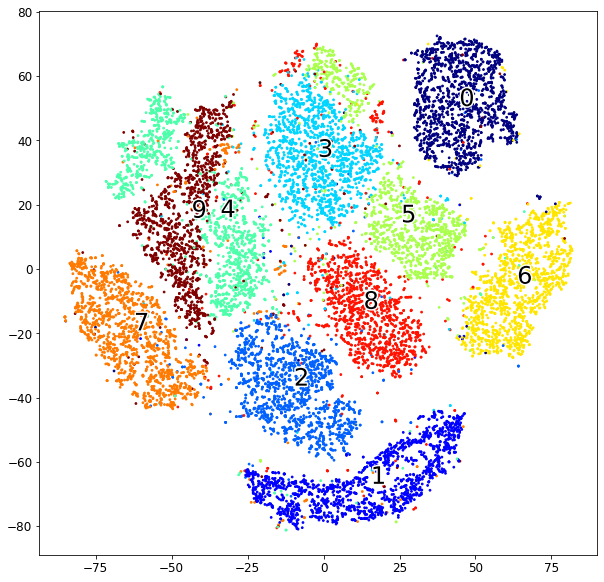

In [15]:
tsne = TSNE(n_components=2, random_state=42)
svd_tsne_value = tsne.fit_transform(U[:,n_comps])
plot_data(svd_tsne_value, y_train, 10)

---
---
# <font color='#f78fb3'> **6 Auto Encoder**<br> </font> 

### 1. Import library

In [16]:
# Deep Learnign libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.display import display, Math, Latex
import datetime

### 2.  Construct architecture

In [17]:


tf.random.set_seed(42)
np.random.seed(42)
keras.backend.clear_session()
tf.keras.backend.clear_session()

# No of Neurons in each layer []
input_dim = X_train.shape[1]
encoding1_dim = 100
encoding2_dim = 500
latent_dim = 20

input_layer = Input(shape=(input_dim, ))
encoder = Dense(int(encoding1_dim), activation="relu")(input_layer)
encoder = Dense(int(encoding2_dim), activation='relu')(encoder)
encoder = Dense(int(latent_dim), activation='relu')(encoder)
decoder = Dense(int(encoding2_dim), activation='relu')(encoder)
decoder = Dense(int(encoding1_dim), activation='relu')(decoder)
decoder = Dense(int(input_dim), activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 500)               50500     
                                                                 
 dense_2 (Dense)             (None, 20)                10020     
                                                                 
 dense_3 (Dense)             (None, 500)               10500     
                                                                 
 dense_4 (Dense)             (None, 100)               50100     
                                                                 
 dense_5 (Dense)             (None, 784)               79184 

In [18]:
# this models maps an input to its encoded representation
encoder_layer = Model(input_layer, encoder)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(int(latent_dim),))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-3]
# create the decoder model
decoder_layer = Model(encoded_input, decoder_layer(encoded_input))

decoder_layer

### 3. Train model

In [19]:
nb_epoch = 20
batch_size = 10
autoencoder.compile(optimizer='adam', loss='mse')

cp = ModelCheckpoint(filepath='autoencoder1.h5', save_best_only=True, verbose=0)
tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
t_ini = datetime.datetime.now()
history = autoencoder.fit(X_train, 
                          X_train, 
                          epochs=nb_epoch, 
                          #batch_size=batch_size, 
                          shuffle=True, 
                          validation_data=(X_valid, X_valid),
                          #verbose=1,
).history
t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))

df_history = pd.DataFrame(history)

Epoch 1/20
469/469 [==============================] - 11s 18ms/step - loss: 0.0431 - val_loss: 0.0305
Epoch 2/20
469/469 [==============================] - 8s 17ms/step - loss: 0.0283 - val_loss: 0.0265
Epoch 3/20
469/469 [==============================] - 8s 18ms/step - loss: 0.0257 - val_loss: 0.0246
Epoch 4/20
469/469 [==============================] - 8s 16ms/step - loss: 0.0240 - val_loss: 0.0237
Epoch 5/20
469/469 [==============================] - 8s 17ms/step - loss: 0.0231 - val_loss: 0.0226
Epoch 6/20
469/469 [==============================] - 8s 17ms/step - loss: 0.0223 - val_loss: 0.0223
Epoch 7/20
469/469 [==============================] - 8s 17ms/step - loss: 0.0216 - val_loss: 0.0214
Epoch 8/20
469/469 [==============================] - 8s 17ms/step - loss: 0.0212 - val_loss: 0.0213
Epoch 9/20
469/469 [==============================] - 9s 18ms/step - loss: 0.0208 - val_loss: 0.0210
Epoch 10/20
469/469 [==============================] - 8s 17ms/step - loss: 0.0205 - val_l

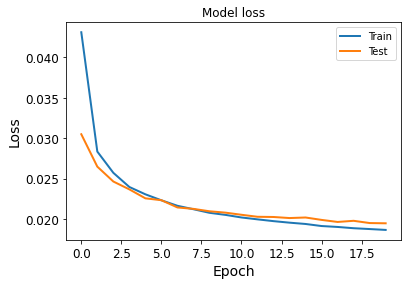

In [20]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

### 4. Transform data to embedding layer

In [21]:
np.random.seed(42)

from sklearn.manifold import TSNE
tsne = TSNE()
X_train_ae = encoder_layer.predict(X_train)
X_train_ae_tsne = tsne.fit_transform(X_train_ae)

#### Visualize transformed data

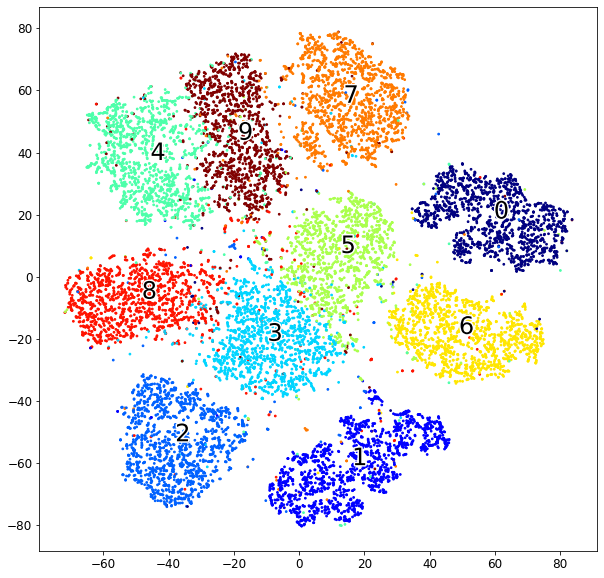

In [22]:
plot_data(X_train_ae_tsne, y_train, 10)

In [23]:
pd.DataFrame(X_train_ae).to_csv('Mnist_ae.csv', index=False)
pd.DataFrame(X_train_ae_tsne).to_csv('Mnist_ae_tsne.csv', index=False)

---
---
# <font color='#f78fb3'> **7 Variational Auto Encoder**<br> </font> 

### 1. Cost function

In [24]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))
        
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

### 2. Train model

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 20

inputs = keras.layers.Input(shape=[784])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(100, activation="selu")(z)
z = keras.layers.Dense(500, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(300, activation="selu")(x)
x = keras.layers.Dense(784, activation="selu")(x)
outputs = keras.layers.Reshape([784])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="mse", optimizer="adam")
history = variational_ae.fit(X_train, X_train, epochs=20, #batch_size=5000,
                             validation_data=(X_valid, X_valid))
df_history = pd.DataFrame(history.history)

Epoch 1/20
469/469 [==============================] - 17s 29ms/step - loss: 0.0629 - val_loss: 0.0544
Epoch 2/20
469/469 [==============================] - 11s 24ms/step - loss: 0.0534 - val_loss: 0.0526
Epoch 3/20
469/469 [==============================] - 11s 23ms/step - loss: 0.0522 - val_loss: 0.0518
Epoch 4/20
469/469 [==============================] - 11s 23ms/step - loss: 0.0515 - val_loss: 0.0509
Epoch 5/20
469/469 [==============================] - 11s 23ms/step - loss: 0.0506 - val_loss: 0.0503
Epoch 6/20
469/469 [==============================] - 12s 26ms/step - loss: 0.0498 - val_loss: 0.0493
Epoch 7/20
469/469 [==============================] - 12s 25ms/step - loss: 0.0491 - val_loss: 0.0486
Epoch 8/20
469/469 [==============================] - 11s 23ms/step - loss: 0.0486 - val_loss: 0.0483
Epoch 9/20
469/469 [==============================] - 12s 26ms/step - loss: 0.0482 - val_loss: 0.0479
Epoch 10/20
469/469 [==============================] - 12s 25ms/step - loss: 0.047

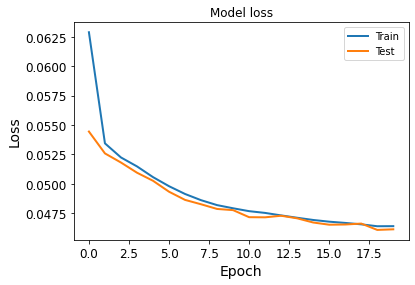

In [26]:
plt.plot(df_history['loss'], linewidth=2, label='Train')
plt.plot(df_history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

### 3.  Transform data to embedding layer

In [27]:
np.random.seed(42)

from sklearn.manifold import TSNE
tsne = TSNE()
X_train_vae = variational_encoder.predict(X_train)[0]

#### Visualize transformed data

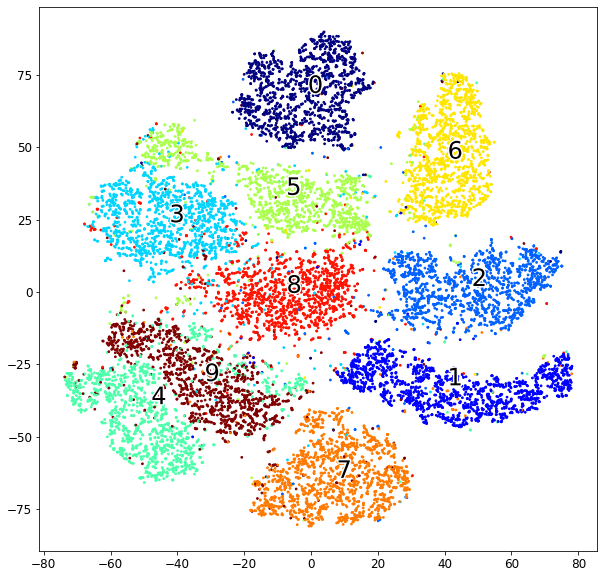

In [28]:
X_train_vae_tsne = tsne.fit_transform(X_train_vae)

plot_data(X_train_vae_tsne, y_train, 10)

---
---
# <font color='#f78fb3'> **8 K-Means**<br> </font> 

### 1. Train K-Means with latent vars from Auto Encoder

In [29]:
from sklearn.cluster import KMeans

k = 10
kmeans = KMeans(n_clusters=k, random_state=9, init='k-means++')
kmeans_cluster = kmeans.fit_predict(X_train_ae)

### 2. Result

#### Visualize clusters

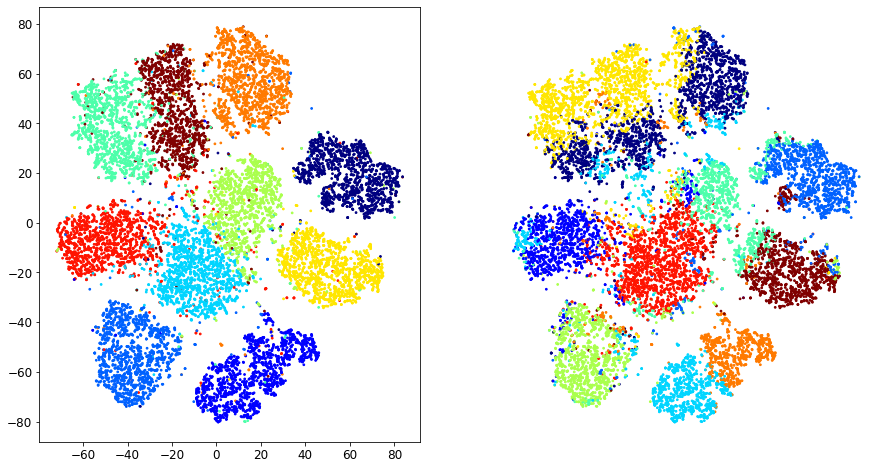

In [30]:
compare_truelabel_cluster(X_train_ae_tsne, y_train, kmeans_cluster)

#### clusters

In [31]:
kmeans.labels_

array([8, 3, 7, ..., 4, 4, 3])

#### centroids

In [32]:
kmeans.cluster_centers_[0:2]

array([[3.2383971, 1.6223717, 2.601496 , 3.0059445, 2.4753463, 3.7201939,
        2.4425259, 0.       , 2.226346 , 1.9688694, 0.       , 5.573414 ,
        0.       , 0.       , 5.2288876, 2.0334172, 3.6789122, 0.       ,
        0.       , 0.       ],
       [2.8123224, 4.0298967, 2.458981 , 2.5119905, 2.7382188, 3.1605217,
        2.7853522, 0.       , 5.5072885, 5.5524926, 0.       , 3.2593644,
        0.       , 0.       , 6.233884 , 2.2205706, 3.7314236, 0.       ,
        0.       , 0.       ]], dtype=float32)

#### inertia metric

In [33]:
kmeans.inertia_

358294.3125

In [34]:
from sklearn.metrics import silhouette_score
silhouette_score(X_train_ae, kmeans.labels_)

0.14288577

### 3. Hard clustering vs. Soft clustering

Instead of assigning each instance to a single cluster, which is called hard clustering, it can be useful just give each instance a score per cluster - this is called soft clustering. The score can be distance between the instance and the centroid

In [35]:
X_new = X_train_ae[0:3]
kmeans.transform(X_new)

array([[7.3011427, 6.432373 , 8.302425 , 7.361214 , 5.967899 , 6.853999 ,
        7.281349 , 6.0437417, 3.8577015, 7.4025583],
       [6.5371065, 6.3724146, 9.903628 , 4.0924673, 7.1833534, 6.898212 ,
        9.064506 , 6.193248 , 8.354104 , 9.39047  ],
       [6.907048 , 8.046196 , 9.937643 , 6.226539 , 7.262899 , 8.8602705,
        7.0548396, 2.1545985, 7.858401 , 7.0041776]], dtype=float32)

### 4. Specifying number of clusters with Elbow Method

In [36]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=9).fit(X_train_ae) for k in range(1, 20)]
inertias = [model.inertia_ for model in kmeans_per_k]

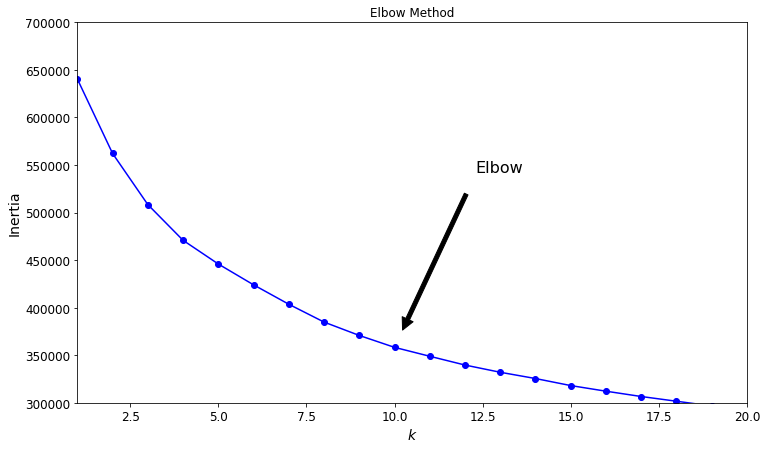

In [37]:
plt.figure(figsize=(12,7))
plt.plot(range(1, 20), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.title('Elbow Method')
plt.annotate('Elbow',
             xy=(10, inertias[9]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 20, 300000, 700000])
plt.show()  

=> There is an elbow at k = 9 or 10, which means that less clusters than that would be bad, and more clusters would not help much. 

### 5. Specifying the number of clsuters with Silhoute score

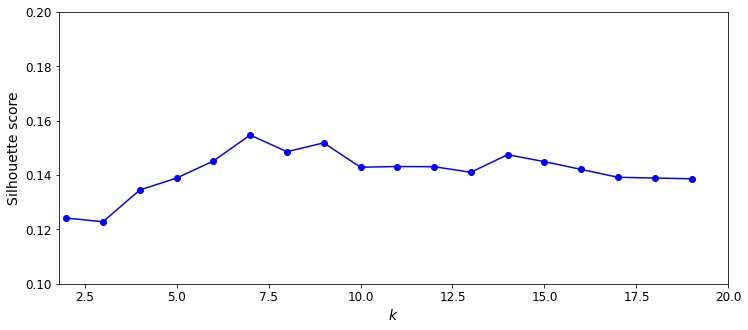

In [38]:
silhouette_scores = [silhouette_score(X_train_ae, model.labels_) for model in kmeans_per_k[1:]]

plt.figure(figsize=(12, 5))
plt.plot(range(2, 20), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 20, 0.1, 0.2])
plt.show()

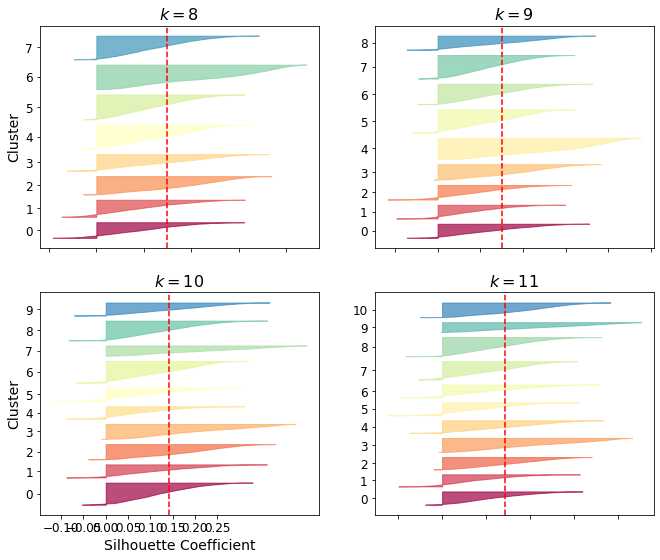

In [39]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (8, 9, 10, 11):
    plt.subplot(2, 2, k - 7)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X_train_ae, y_pred)

    padding = len(X_train_ae) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (8, 10):
        plt.ylabel("Cluster")
    
    if k in (10, 12):
        plt.gca().set_xticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
plt.show()

---
---
# <font color='#f78fb3'> **9 Gaussian Mixtures Model**<br> </font> 

### 1. Train model

In [40]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=10, n_init=10, random_state=9)
gm.fit(X_train_ae)

GaussianMixture(n_components=10, n_init=10, random_state=9)

### 2.  Result

#### Visualization

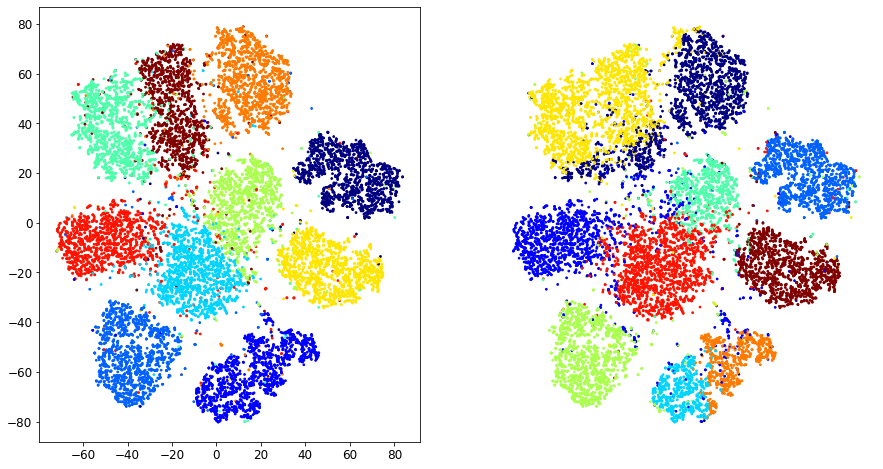

In [41]:
compare_truelabel_cluster(X_train_ae_tsne, y_train, gm.predict(X_train_ae))

#### Parameters values

In [42]:
gm.weights_

array([0.12864513, 0.12279176, 0.09638514, 0.04679344, 0.06349839,
       0.10491812, 0.15824115, 0.05353984, 0.13033336, 0.09485367])

In [43]:
gm.means_[0:2]

array([[3.12450402, 1.79383564, 2.73858192, 2.9416511 , 2.24736079,
        3.05258973, 2.64012233, 0.        , 1.95901778, 1.77222383,
        0.        , 5.53810517, 0.        , 0.        , 5.3155226 ,
        2.04414476, 3.93584077, 0.        , 0.        , 0.        ],
       [2.85722924, 3.67555371, 2.26090774, 2.46243418, 2.7420682 ,
        2.99623837, 3.10617528, 0.        , 4.98433154, 4.73317836,
        0.        , 3.00601949, 0.        , 0.        , 5.55041376,
        2.25050502, 3.39135394, 0.        , 0.        , 0.        ]])

In [44]:
gm.covariances_[0:2]

array([[[ 2.16823171e+00, -2.70169526e-01,  4.66887634e-02,
         -9.58368000e-02,  8.85273379e-01,  1.01409976e+00,
          3.57124791e-01,  0.00000000e+00,  9.92401208e-02,
          6.97477742e-01,  0.00000000e+00, -4.21181747e-01,
          0.00000000e+00,  0.00000000e+00,  5.17908960e-01,
          2.98471980e-02, -5.11300508e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-2.70169526e-01,  1.23082674e+00,  3.20104728e-01,
         -3.18676882e-01, -3.23200872e-01, -4.20526556e-01,
          3.74558635e-01,  0.00000000e+00,  2.71895192e-01,
         -1.68815521e-01,  0.00000000e+00,  8.68229741e-01,
          0.00000000e+00,  0.00000000e+00,  2.16894601e-01,
          3.59250340e-01,  2.87007840e-01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 4.66887634e-02,  3.20104728e-01,  2.18729304e+00,
          5.46010690e-01, -1.39301542e-01, -5.04618716e-01,
         -3.68888127e-01,  0.00000000e+00,  3.89831899e-02,
          2.

Did the algorithm actually converge?

In [45]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [46]:
gm.n_iter_

23

### 3. Prediction

In [47]:
gm.predict(X_train_ae)

array([8, 3, 7, ..., 4, 9, 1], dtype=int64)

In [48]:
gm.predict_proba(X_train_ae)

array([[1.27435274e-015, 2.57282591e-003, 6.65504910e-023, ...,
        1.88623961e-080, 9.97427103e-001, 1.70279125e-011],
       [6.88299868e-009, 2.67559991e-005, 1.00249262e-030, ...,
        2.11584936e-016, 2.07822763e-010, 5.55561671e-021],
       [1.36599346e-012, 4.40949794e-007, 4.69088780e-020, ...,
        9.99999543e-001, 9.43750418e-011, 4.35482436e-015],
       ...,
       [9.89085487e-020, 1.01643716e-007, 2.12038164e-015, ...,
        1.03682375e-111, 6.73744196e-003, 7.83216562e-022],
       [1.10248127e-014, 4.69336855e-006, 3.21389506e-006, ...,
        3.34453302e-179, 1.54859717e-010, 9.99975027e-001],
       [8.18233686e-007, 9.83247564e-001, 5.72404345e-015, ...,
        1.15249079e-119, 2.01880165e-005, 1.36710131e-009]])

### 4. Visualize clusters

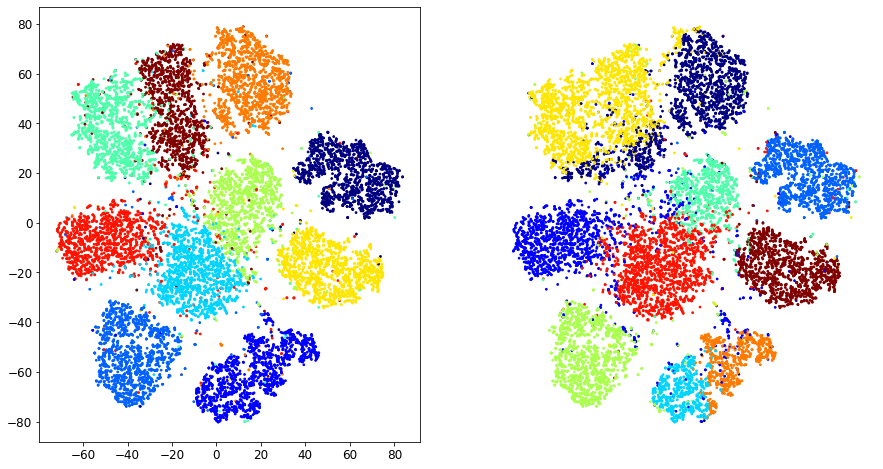

In [49]:
gm_full = GaussianMixture(n_components=10, n_init=10, covariance_type="full", random_state=9)
gm_full.fit(X_train_ae)
compare_truelabel_cluster(X_train_ae_tsne, y_train, gm_full.predict(X_train_ae))

### 5. Select number of clusters

In [50]:
gm.bic(X_train_ae)

-585943.2614703897

In [51]:
gm.aic(X_train_ae)

-603528.1563239044

In [52]:
n_clusters = 10
n_dims = 20
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X_train_ae) * len(X_train_ae) # log(L^)
bic = np.log(len(X_train_ae)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [53]:
bic, aic

(-585943.2614703897, -603528.1563239044)

In [54]:
n_params

2309

There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. Similarly, the degrees of freedom for an $n \times n$ covariance matrix is not $n^2$, but $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

In [55]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=9).fit(X_train_ae)
             for k in range(1, 20)]

In [56]:
bics = [model.bic(X_train_ae) for model in gms_per_k]
aics = [model.aic(X_train_ae) for model in gms_per_k]

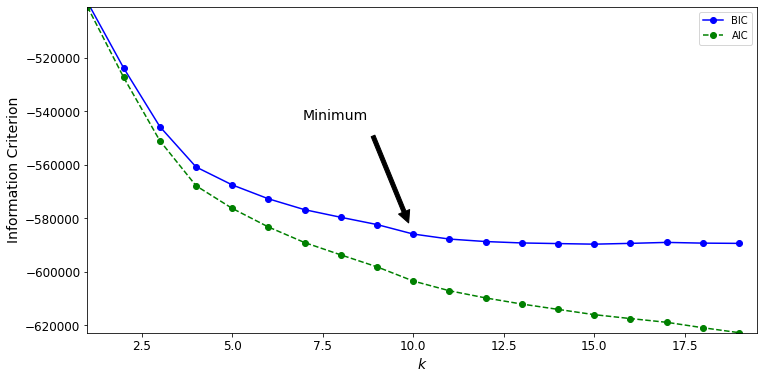

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 20), bics, "bo-", label="BIC")
plt.plot(range(1, 20), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 19.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(10, bics[9]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

Let's search for best combination of values for both the number of clusters and the `covariance_type` hyperparameter:

---
---
# <font color='#f78fb3'> **10. Hierarchical Clustering**<br> </font> 

### 1. Train model and prediction

In [58]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage = 'complete')
y_agglo = agglo.fit_predict(X_train_ae)

### 2. Results

#### Visualize clusters

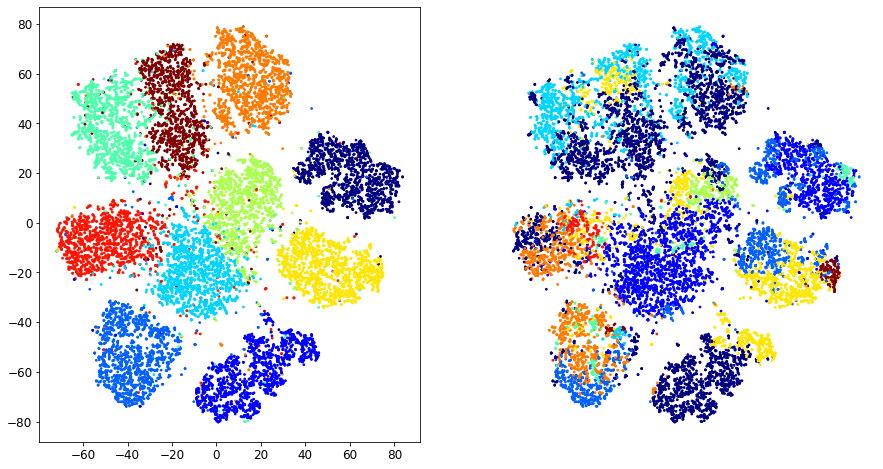

In [59]:
compare_truelabel_cluster(X_train_ae_tsne, y_train, y_agglo)